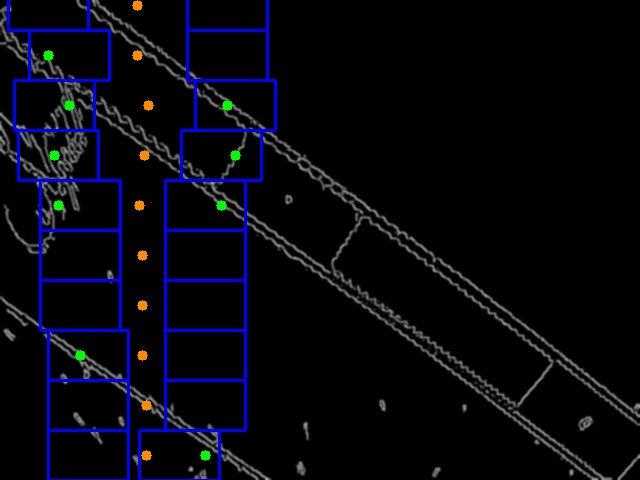

In [ ]:
import cv2
import numpy as np
import RPi.GPIO as GPIO
from time import sleep
from pinkylib import Camera
from pinkylib import Pinky

# GPIO 핀 번호 설정
IN1 = 17
IN2 = 27
ENA = 18
IN3 = 5
IN4 = 6
ENB = 13
STBY = 25

# 모터 설정 함수
def setup_gpio():
    GPIO.setmode(GPIO.BCM)
    GPIO.setup(IN1, GPIO.OUT)
    GPIO.setup(IN2, GPIO.OUT)
    GPIO.setup(ENA, GPIO.OUT)
    GPIO.setup(IN3, GPIO.OUT)
    GPIO.setup(IN4, GPIO.OUT)
    GPIO.setup(ENB, GPIO.OUT)
    GPIO.setup(STBY, GPIO.OUT)
    global pwmA, pwmB
    pwmA = GPIO.PWM(ENA, 1000)
    pwmB = GPIO.PWM(ENB, 1000)
    pwmA.start(0)
    pwmB.start(0)

# 모터 제어 함수
def set_motor(channel, state):
    if channel == 'A':
        GPIO.output(IN1, state[0])
        GPIO.output(IN2, state[1])
    elif channel == 'B':
        GPIO.output(IN3, state[0])
        GPIO.output(IN4, state[1])

def motor_forward(channel, speed):
    set_motor(channel, (GPIO.HIGH, GPIO.LOW))
    if channel == 'A':
        pwmA.ChangeDutyCycle(speed)
    elif channel == 'B':
        pwmB.ChangeDutyCycle(speed)

def motor_backward(channel, speed):
    set_motor(channel, (GPIO.LOW, GPIO.HIGH))
    if channel == 'A':
        pwmA.ChangeDutyCycle(speed)
    elif channel == 'B':
        pwmB.ChangeDutyCycle(speed)

def motor_stop():
    pwmA.ChangeDutyCycle(0)
    pwmB.ChangeDutyCycle(0)

# 카메라 설정
cam = Camera()
cam.start()
WIDTH = 640
HEIGHT = 480
h1 = 0.725
h2 = 0.4
w1 = 0.25

pinky = Pinky()

def bird_eye_view(img):
    src_point = np.array([[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]], dtype=np.float32)
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    return cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def find_edges_and_draw_windows(img, window_height=50, window_width=80, min_val=50, num_windows=10):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    y_start = height - window_height
    y_end = height
    left_center_x, right_center_x = None, None
    left_visible, right_visible = False, False  # 차선 감지 상태 변수 추가
    last_left_center_x, last_right_center_x = None, None  # 마지막 감지 위치 저장 변수 추가

    # 왼쪽 차선 탐지
    for x in range(window_width, width - window_width):
        if img[y_start:y_end, x].any():
            left_center_x = x
            left_visible = True
            break

    if left_center_x is not None:
        last_left_center_x = left_center_x  # 마지막 위치 업데이트
        for x in range(left_center_x + window_width * 2, width):
            if img[y_start:y_end, x].any():
                right_center_x = x
                right_visible = True
                break

    if right_center_x is not None:
        last_right_center_x = right_center_x  # 마지막 위치 업데이트

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        if left_center_x is not None:
            left_window_x_start = max(0, left_center_x - window_width // 2)
            left_window_x_end = min(width, left_center_x + window_width // 2)
            left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]
            left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
            if left_lines is not None:
                left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
                left_center_x = int(np.mean(left_centers)) + left_window_x_start
                last_left_center_x = left_center_x  # 감지된 위치 업데이트
                cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)

        if right_center_x is not None:
            right_window_x_start = max(0, right_center_x - window_width // 2)
            right_window_x_end = min(width, right_center_x + window_width // 2)
            right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]
            right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
            if right_lines is not None:
                right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
                right_center_x = int(np.mean(right_centers)) + right_window_x_start
                last_right_center_x = right_center_x  # 감지된 위치 업데이트
                cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        if left_center_x is not None and right_center_x is not None:
            center_x = (left_center_x + right_center_x) // 2
            center_y = (y_start + y_end) // 2
            cv2.circle(output_img, (center_x, center_y), 5, (0, 140, 255), -1)
    
    return output_img, center_x if left_center_x is not None and right_center_x is not None else None, left_visible, right_visible, last_left_center_x, last_right_center_x


def line_tracing(center_x, left_visible, right_visible, last_left_center_x, last_right_center_x, speed=60):
    if center_x is None:
        motor_forward('A', speed * 0.80)
        motor_forward('B', speed * 0.42)
                
    elif center_x < (WIDTH // 9) * 4:
        motor_forward('A', speed * 0.83)
        motor_forward('B', speed * 0.92)
    elif center_x < (WIDTH // 9) * 3:
        motor_forward('A', speed * 0.67)
        motor_forward('B', speed * 0.83)
    elif center_x < (WIDTH // 9) * 2:
        motor_forward('A', speed * 0.60)
        motor_forward('B', speed * 0.83)
    elif center_x > (WIDTH // 9) * 6:
        motor_forward('A', speed * 0.92)
        motor_forward('B', speed * 0.83)
    elif center_x > (WIDTH // 9) * 7:
        motor_forward('A', speed * 0.83)
        motor_forward('B', speed * 0.67)
    elif center_x > (WIDTH // 9) * 8:
        motor_forward('A', speed * 0.83)
        motor_forward('B', speed * 0.60)
    else:
        motor_forward('A', speed)
        motor_forward('B', speed)


roi_rows, roi_cols = 5, 5
roi_height = HEIGHT // roi_rows
roi_width = WIDTH // roi_cols

# 추적할 색상의 HSV 범위 설정 (파란색 범위 예시)
lower_color = np.array([100, 150, 0])
upper_color = np.array([150, 255, 255])


def count_detected_rois(frame, threshold_ratio=0.1):
    # BGR에서 HSV 색상 공간으로 변환
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # 지정한 색상 범위에 해당하는 부분을 추출하기 위해 마스크 생성
    color_mask = cv2.inRange(hsv_frame, lower_color, upper_color)
    
    # 20% 이상 검출된 ROI 개수 초기화
    detected_roi_count = 0
    
    # 각 ROI 영역에서 차지한 비율을 계산
    for row in range(roi_rows):
        for col in range(roi_cols):
            # ROI 좌표 계산
            x_start = col * roi_width
            y_start = row * roi_height
            x_end = x_start + roi_width
            y_end = y_start + roi_height
            
            # 해당 ROI에 대한 마스크 부분 추출
            roi_mask = color_mask[y_start:y_end, x_start:x_end]
            total_pixels = roi_mask.size
            detected_pixels = cv2.countNonZero(roi_mask)
            
            # ROI에서 색상 검출 비율 계산
            detection_ratio = detected_pixels / total_pixels
            
            # 검출 비율이 지정된 threshold_ratio 이상인 경우 개수 증가 및 사각형 표시
            if detection_ratio >= threshold_ratio:
                detected_roi_count += 1
                # 해당 ROI에 사각형 표시 (녹색 테두리, 두께 2)
                cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
    
    return detected_roi_count

################################################################################################################################################
setup_gpio()
GPIO.output(STBY, GPIO.HIGH)
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)
    detected_roi_count = count_detected_rois(frame)
    result_img, center_x, left_visible, right_visible, last_left_center_x, last_right_center_x = find_edges_and_draw_windows(smoothed_line)
    cam.display_jupyter(result_img)
    print(f"20% 이상 색상 검출된 ROI 개수: {detected_roi_count}")
    if(detected_roi_count <= 2):
        lineSpeed = 60
    elif(detected_roi_count <= 5):
        lineSpeed = 60 - ( detected_roi_count * 4 )
    elif(detected_roi_count <= 10):
        lineSpeed = 60 - ( detected_roi_count * 4 )
    else:
        lineSpeed = 0
    line_tracing(center_x, left_visible, right_visible, last_left_center_x, last_right_center_x, lineSpeed)

cam.stop()
cleanup()
